<a href="https://colab.research.google.com/github/Marcelle-git/Sentiment-Analysis-project/blob/main/DeepLearning_Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Access to my drive because I imported the image dataset in my Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import the zipfile library for extracting the files that I imported on Drive and copy the paths for loading images

In [ ]:
#import zipfile


In [ ]:
#zip_train = zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r')
#zip_train.extractall('/content/drive/MyDrive/Colab Notebooks')
#zip_train.close()

Loading image dataset train and test

In [ ]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/seg_train/seg_train'
validation_dataset_path = '/content/drive/MyDrive/Colab Notebooks/seg_test/seg_test'

In [ ]:
IMG_WIDTH = 150       #Here are the the size of the images
IMG_HEIGHT = 150
BATCH_SIZE = 32       #I define the batch size

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255,       #We apply data augmentation for increasing the size of the dataset and adding rotation or zoom for better generalization of CNN model
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   #classes = ['buildings','forest','glacier', 'mountain', 'sea', 'street'],
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


In [ ]:
train_generator.class_indices      #Overview of the classes presented in the dataset

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)                                   #We also defined a validation dataset for evaluating the model performance duraing the training
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             #classes = ['buildings','forest','glacier', 'mountain', 'sea', 'street'],
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


In [ ]:
labels = {value: key for key, value in train_generator.class_indices.items()}          #We define the labels of the different classes

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


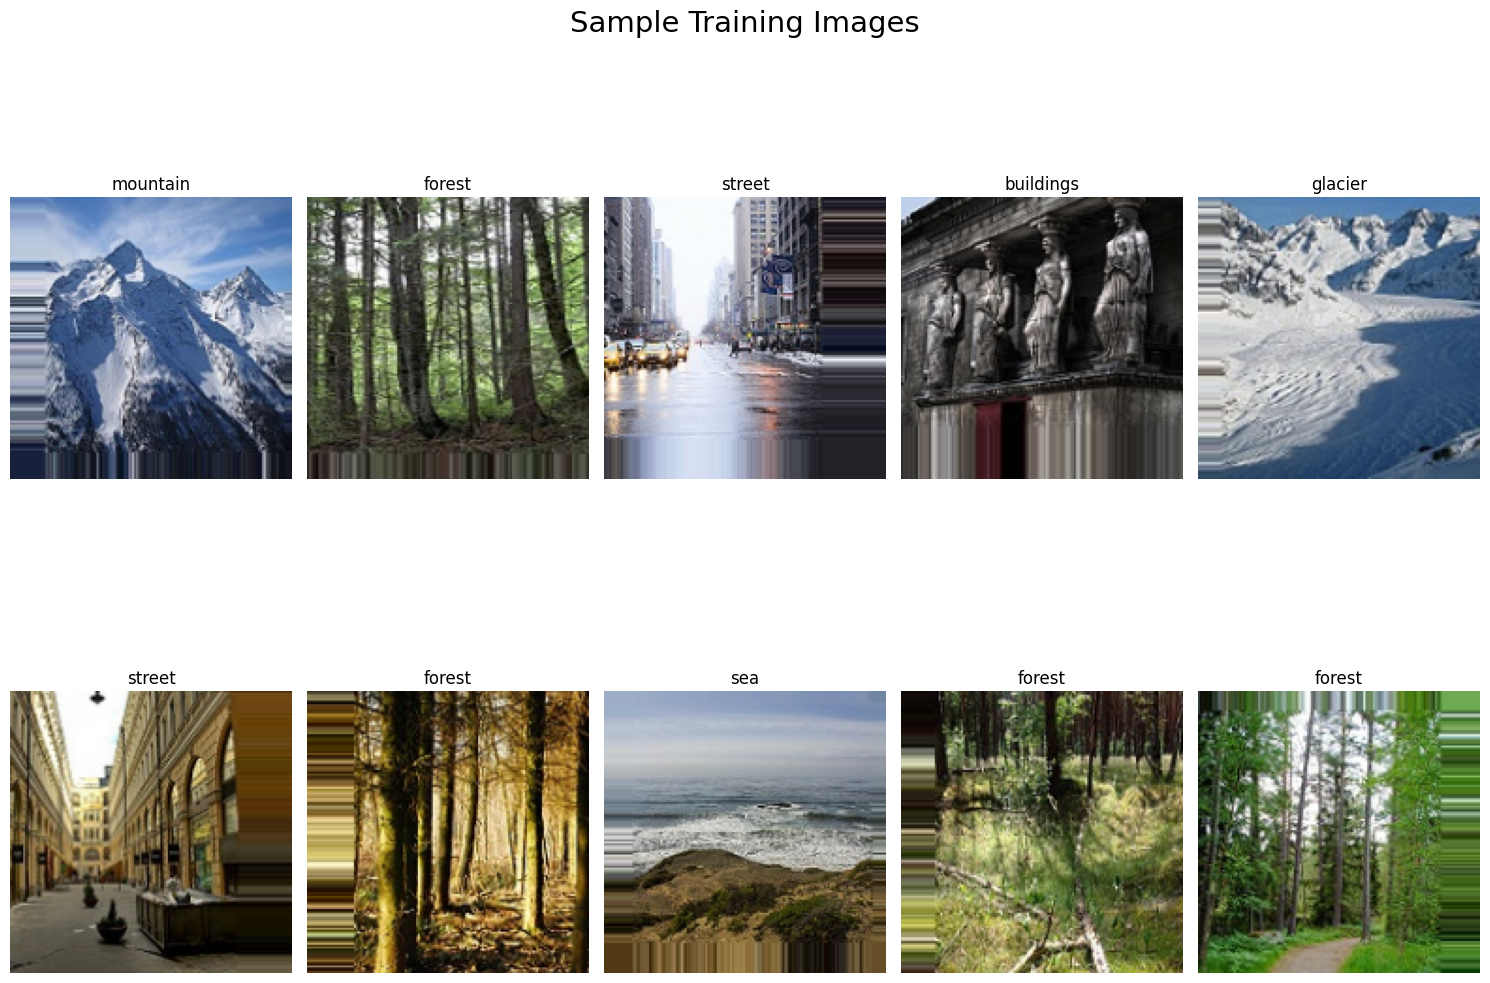

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))         #Overview of the training images
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

Building of the model

In [ ]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),        #ReLu is our activation function
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),   #
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),                         #We specified 3 conv2D layers in the sequential order ; then we use Flatten and have 2 dense layer; the last layer has 6 units units which represent the number of classes and is activated with softmax function instead of ReLu
                                                      #It's important to define a good number of layers for extracting the maximum or all the features of the images otherwise it can lead to an overfitting with more layers or an underfitting with less layers
        Flatten(),

        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])

    return model

In [ ]:
cnn_model = create_model()

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)         #We define a callback called Reduce Learning Rate on Plateau;It is used to reduce the learning rate when a metric has stopped improving.

In [ ]:
optimizer = Adam(learning_rate=0.001)      #We choose the Adam optimizer for minimizing our loss function which is categoricalcrossentropy

In [ ]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy']) #Then we compile the model for training step

In [ ]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


In [ ]:
test_dataset = '/content/drive/MyDrive/Colab Notebooks/seg_test/seg_test'   #Loading of the test dataset

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

In [ ]:
predictions = cnn_model.predict(test_generator) #We make some predictions

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
print(classification_report(y_true, y_pred, target_names=labels.values()))   #Then we plot the classification metrics for seeing the performance of the CNN model